In [56]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
import ta
import ccxt
import pandas_ta as pda

In [57]:
# pairList = pairJson['hitbtc2018']
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2018-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)

Successfully load 36132 candles for ETHUSDT


In [58]:
# -- Indicator variable --
trixLength = 9
trixSignal = 21
stochWindow = 14

# -- Drop all columns we do not need --
df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)

# -- Indicators, you can edit every value --
df['TRIX'] = ta.trend.ema_indicator(ta.trend.ema_indicator(ta.trend.ema_indicator(close=df['close'], window=trixLength), window=trixLength), window=trixLength)
df['TRIX_PCT'] = df["TRIX"].pct_change()*100
df['TRIX_SIGNAL'] = ta.trend.sma_indicator(df['TRIX_PCT'], trixSignal)
df['TRIX_HISTO'] = df['TRIX_PCT'] - df['TRIX_SIGNAL']
df['STOCH_RSI'] = ta.momentum.stochrsi(close=df['close'], window=stochWindow, smooth1=3, smooth2=3)

print("Indicators loaded 100%")
df

Indicators loaded 100%


,open,high,low,close,volume,TRIX,TRIX_PCT,TRIX_SIGNAL,TRIX_HISTO,STOCH_RSI
timestamp,,,,,,,,,,
2018-01-01 00:00:00,733.01,734.52,720.03,727.62,2105.90100,NaN,NaN,NaN,NaN,NaN
2018-01-01 01:00:00,727.01,732.00,716.80,717.97,2305.97086,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,717.67,725.75,717.59,724.05,2166.45725,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,723.95,737.99,722.70,734.50,2160.90450,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,734.99,744.98,730.01,744.82,2335.33705,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2022-02-19 06:00:00,2809.28,2825.98,2803.35,2819.61,12220.41860,2824.994040,-0.108258,-0.183367,0.075109,1.000000
2022-02-19 07:00:00,2819.61,2825.00,2807.36,2812.05,6283.07500,2822.483896,-0.088855,-0.181559,0.092705,0.890533
2022-02-19 08:00:00,2812.05,2819.33,2780.04,2781.82,14630.24800,2820.191841,-0.081207,-0.180020,0.098813,0.508114


In [59]:
# -- Intern parameter --
dfTest = df['2018-01-01':]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Rules --
StopLossActivation = False
takeProfitActivation = False
timeLimitActivation = False
showLog = False
waitNextSignal = False

# -- Hyper parameters --
stochOverBought = 0.85
stochOverSold = 0.25
SlPct = 0.02
TpPct = 0.02
timeLimit = 17


# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(row, previousRow):
    if row['TRIX_HISTO'] >= 0 and row['STOCH_RSI'] < stochOverBought:
        return True
    else:
        return False

# -- Condition to SELL market --


def sellCondition(row, previousRow):
    if row['TRIX_HISTO'] < 0:
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
lastAth = 0
previousRow = dfTest.iloc[0]
stopLoss = 0
takeProfit = 500000
currentTimeOpen = 0
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    timeSince += 1
    if currentTimeOpen > 0:
        currentTimeOpen += 1
    # -- Buy market order --
    if buyCondition(row, previousRow) and usd > 0:
        # -- You can define here at what price you buy --
        buyPrice = row['close']
        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        if showLog:
            print("Buy COIN at", buyPrice, '$ the', index)

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0
    # -- Sell Market Order --
    elif sellCondition(row, previousRow):
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            wallet = usd

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0
    previousRow = row

print("Final wallet", wallet)
print(dfTrades)


Final wallet 96455.73446281096
                    date position             reason    price      frais  \
0    2018-01-03 20:00:00      Buy   Buy Market Order   913.01   0.700000   
1    2018-01-04 10:00:00     Sell  Sell Market Order   931.99   0.714052   
2    2018-01-04 15:00:00      Buy   Buy Market Order   989.95   0.713552   
3    2018-01-04 20:00:00     Sell  Sell Market Order   954.00   0.687158   
4    2018-01-05 08:00:00      Buy   Buy Market Order  1009.98   0.686677   
...                  ...      ...                ...      ...        ...   
1854 2022-02-17 00:00:00      Buy   Buy Market Order  3150.99  72.637300   
1855 2022-02-17 05:00:00     Sell  Sell Market Order  3068.92  70.695883   
1856 2022-02-18 10:00:00      Buy   Buy Market Order  2917.30  70.646396   
1857 2022-02-18 18:00:00     Sell  Sell Market Order  2794.02  67.613640   
1858 2022-02-19 03:00:00      Buy   Buy Market Order  2805.38  67.566311   

               fiat      coins         wallet timeSince 

In [60]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : ETH/USDT | Timeframe : 1h
Period : [2018-01-01 00:00:00] -> [2022-02-19 10:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 96455.73 $
Performance vs US Dollar : 9552.33 %
Buy and Hold Performence : 280.43 %
Performance vs Buy and Hold : 2437.24 %
Best trade : +31.41 %, the 2021-01-04 10:00:00
Worst trade : -18.18 %, the 2018-01-17 14:00:00
Worst drawDown : - 45.71 %
Total fees :  49669.18 $

----- Trades Informations -----
Total trades on period : 929
Number of positive trades : 435
Number of negative trades :  494
Trades win rate ratio : 46.82 %
Average trades performance : 0.65 %
Average positive trades : 3.55 %
Average negative trades : -1.91 %

----- Time Informations -----
Average time duration for a trade : 16.84 periods
Maximum time duration for a trade : 63 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 22.02 periods
Maximum time duration between two trades : 69 periods
Minimum t

----- 2018 Performances: 251.37% -----


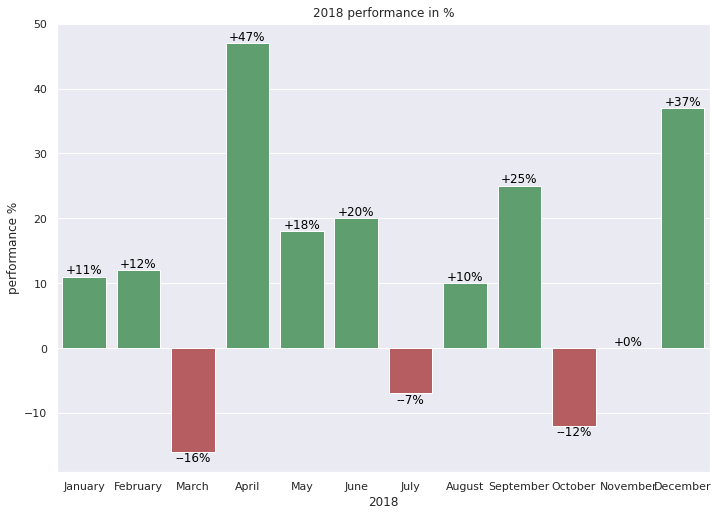

----- 2019 Performances: 169.17% -----


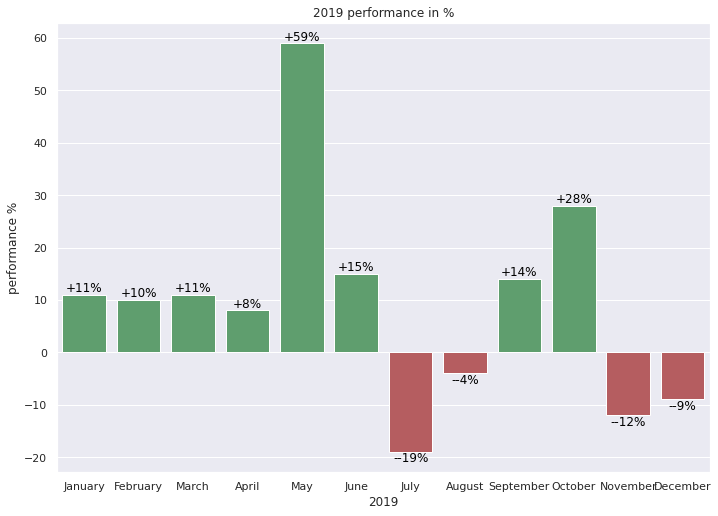

----- 2020 Performances: 264.21% -----


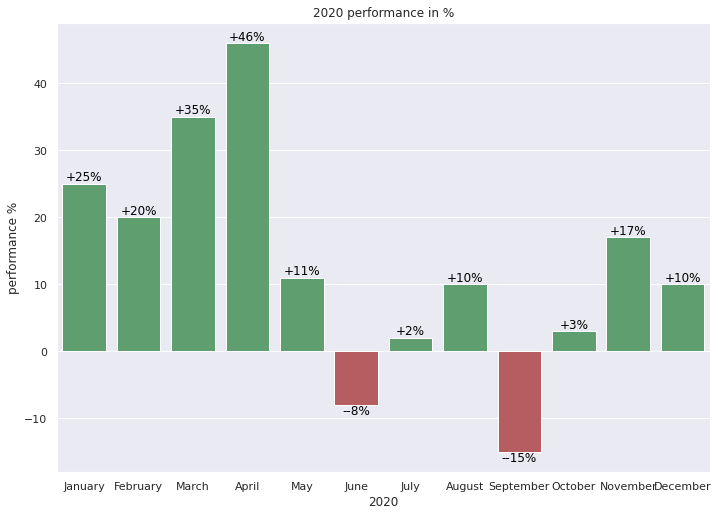

----- 2021 Performances: 227.64% -----


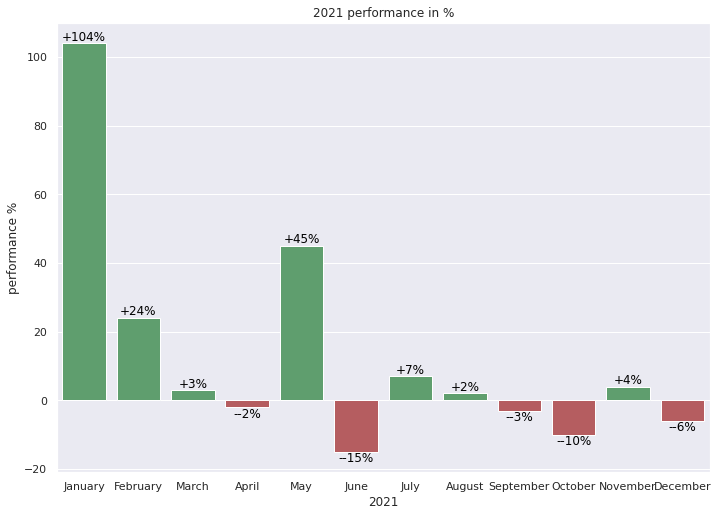

----- 2022 Performances: -14.23% -----


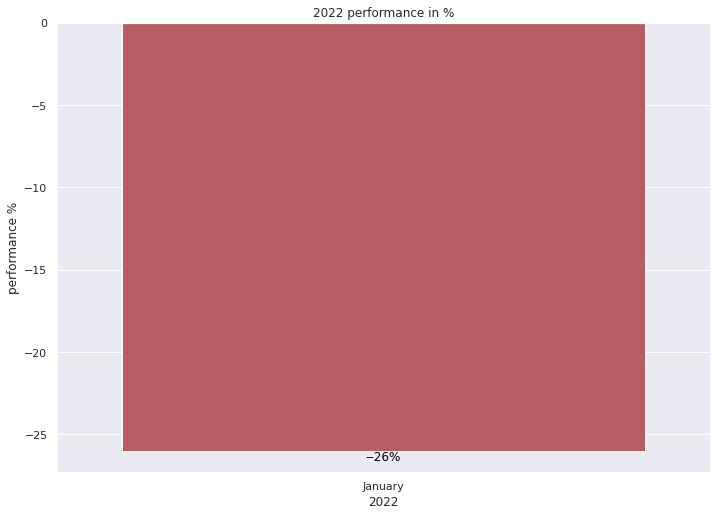

In [61]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


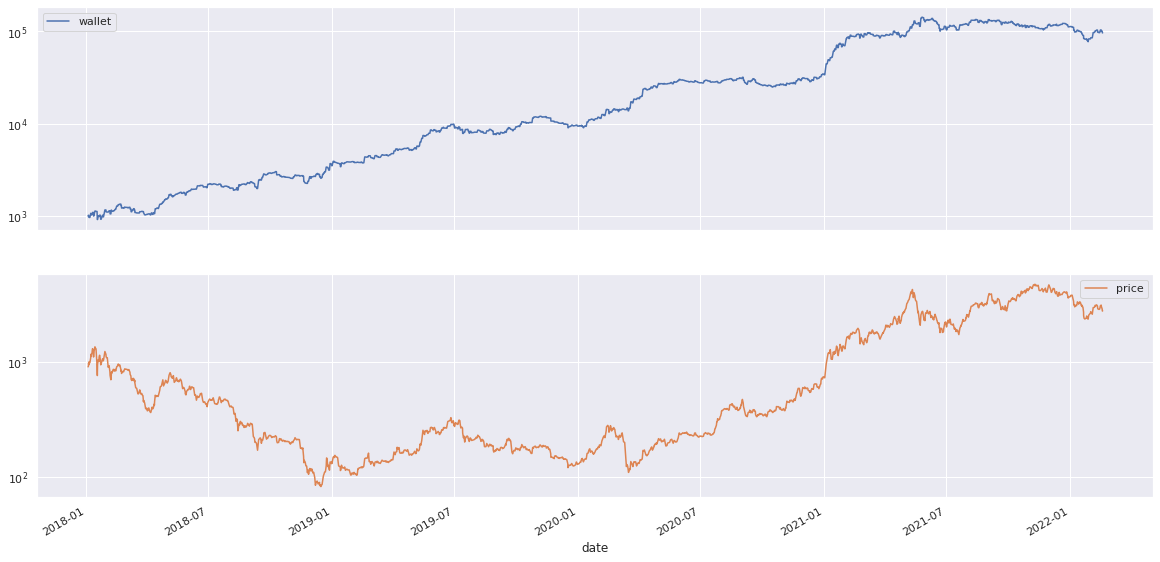

In [62]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)